<a href="https://colab.research.google.com/github/rradams/MUSA650_RemoteSensing_Final/blob/main/Urban_Expansion_Final_Code_both_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MUSA 650: Remote Sensing - Final Project**

Identifying Urban Expansion in Cirebon, Indonesia

Rebekah Adams and Tiffany Tran

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import math
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import RMSprop # optimizer
import keras
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


# Set up functions

In [4]:
import pandas as pd

# Create dataframe of prediction accuracies

def prediction_by_category(model, test_set):
  categories_dict = {1:"Urban", 0:"Not_Urban"}
  predict_x=model.predict(test_set) # predictions with probabilities for each class

  # find accurate predictions
  label_count = np.unique(Y_test, return_counts = True)[1] # number of labels of test set
  classes_x=np.argmax(predict_x,axis=1) # the class with the highest-predicted probabilities, i.e. the best guess
  y_test_pred = [categories_dict[x] for x in classes_x] # convert the predictions to the category names
  y_test_true = [categories_dict[x] for x in Y_test] # convert the true labels to the category names

  # Create dataframe
  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)

  return(pred_df)

In [5]:
# Create function to plot confusion matrix
def plot_cm(model, test_data, title):
  predict_x = model.predict(test_data)
  classes_x = np.argmax(predict_x, axis=1)
  cm = confusion_matrix(Y_test, classes_x)
  disp = ConfusionMatrixDisplay(confusion_matrix= cm,
                                display_labels=categories)
  
  return(
      disp.plot(),
      disp.ax_.set_title(f"{title}")
  )

In [6]:
# Create function to plot ROC curve - how to make less angular?
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_set):
  predict_x=model.predict(test_set) # predictions with probabilities for each class
  classes_x=np.argmax(predict_x,axis=1) # the class with the highest-predicted probabilities, i.e. the best guess

  # Compute fpr, tpr, thresholds and roc auc
  fpr, tpr, thresholds = roc_curve(Y_test, classes_x)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  return(
      plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc),
      plt.plot([0, 1], [0, 1], 'k--'),  # random predictions curve
      plt.xlim([0.0, 1.0]),
      plt.ylim([0.0, 1.0]),
      plt.xlabel('False Positive Rate or (1 - Specifity)'),
      plt.ylabel('True Positive Rate or (Sensitivity)'),
      plt.title('Receiver Operating Characteristic'),
      plt.legend(loc="lower right")
  )


In [7]:
  # Plot images of False Positives - images that were predicted as Urban, but were actually Not Urban
  # This could help us identify areas of urban expansion

from mpl_toolkits.axes_grid1 import ImageGrid

def plot_false_positives(model, test_set):

    predict_x = model.predict(test_set)
    classes_x = np.argmax(predict_x,axis=1)
    wrong_classifications = classes_x - Y_test # predicted classes - actual classes
    wrong_classifications_index = np.where(wrong_classifications != 0) # index of where predictions were wrong
    wrong_predictions = classes_x[wrong_classifications_index] # use index to find wrong predictions
    wrong_y_true = Y_test[wrong_classifications_index] # use index to find correct labels of wrong predictions
    wrong_x_true = X_test[wrong_classifications_index] # use index to find pixels of incorrectly-predicted images

    # Identify False Positive - true Not Urban, predicted as Urban
    FP_index = np.where(wrong_y_true == 0) # find labels Not Urban areas, i.e. the false positives (Non-Urban labelled as 0)
    FP_labels = wrong_y_true[FP_index]
    FP_images = wrong_x_true[FP_index]

    # Select random sample of images from false positive results
    index_list = []

    for i in range(0,4):
      random_index = np.random.choice(FP_labels.shape[0])
      index_list.append(random_index)

    # Use random index to select four random images
    image_1 = FP_images[index_list[0]].reshape(64,64,3)
    image_2 = FP_images[index_list[1]].reshape(64,64,3)
    image_3 = FP_images[index_list[2]].reshape(64,64,3)
    image_4 = FP_images[index_list[3]].reshape(64,64,3)

    # Plot
    fig = plt.figure() #figsize=(4., 4.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )

    for ax, im in zip(grid, [image_1, image_2, image_3, image_4]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)

    return(grid.axes_all[1].set_title("Examples of False Positive Classifications - Predicted as Urban, but are officially not urban"))

In [8]:
# Function to plot accuracy and loss for each model
def plot_accuracy_and_loss(model_history):
  return(
    plt.plot(model_history.history['accuracy']),
    plt.plot(model_history.history['val_accuracy']),
    plt.title('model accuracy'),
    plt.ylabel('accuracy'),
    plt.xlabel('epoch'),
    plt.legend(['train', 'test'], loc='upper left'),
    plt.show(),

    plt.plot(model_history.history['loss']),
    plt.plot(model_history.history['val_loss']),
    plt.title('model loss'),
    plt.ylabel('loss'),
    plt.xlabel('epoch'),
    plt.legend(['train', 'test'], loc='upper left'),
    plt.show(),
  )

# Import images

In [9]:
# pip install imagecodecs

In [10]:
# import images

import os
import skimage
from skimage import io
import numpy as np
from glob import glob
from pathlib import Path
#import imagecodecs

raw_labels =[]
raw_images = []
raw_label_names = []
here = Path(os.getcwd())

for idx, directory in enumerate(sorted((here / "drive/MyDrive/MUSA650_RemoteSensing_Final/data/").glob("*"))):  # keep this line for running on colab
#for idx, directory in enumerate((here / "./data/cirebon").glob("*")):  # Keep this line for running locally
    for img_path in directory.glob("*.jpg"):
        raw_labels.append(idx)
        raw_label_names.append(directory)
        raw_images.append(io.imread(img_path))
        
# convert to numpy arrays
images = np.array(raw_images)
images = images[:, :64, :64, :3] # trim extra pixel and alpha channel
labels = np.array(raw_labels)
label_names = np.array(raw_label_names)

In [11]:
label_names

array([PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/not_urban'),
       ...,
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban'),
       PosixPath('/content/drive/MyDrive/MUSA650_RemoteSensing_Final/data/urban')],
      dtype=object)

In [12]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [13]:
# Switch 0s to 1s and 1s to 0s (so urban = 1, not_urban = 0) - test only
# labels_test = labels

# # flip 1s to 0s and 0s to 1s
# array_flip = np.logical_not(labels_test).astype(int)

# # print old vs. new array
# print(labels_test)
# print(array_flip)

In [14]:
# # Switch 0s to 1s and 1s to 0s (so urban = 1, not_urban = 0)
# # flip 1s to 0s and 0s to 1s
# labels_flip = np.logical_not(labels).astype(int)

# # print old vs. new array
# print(labels)
# print(labels_flip)

In [15]:
# Confrim the range of values in the dataset - yes, they are between 0 and 255
print("Max pixel value is: ", images.max())
print("Min pixel value is: ", images.min())

Max pixel value is:  255
Min pixel value is:  0


In [16]:
urban_labels_index = np.where(labels == 1)
urban_labels = labels[urban_labels_index]
urban_images = images[urban_labels_index]

In [17]:
# Draw out just the non-urban images
non_urban_labels_index = np.where(labels == 0)
non_urban_labels = labels[non_urban_labels_index]
non_urban_images = images[non_urban_labels_index]

# Generate a random selection of non-urban images - the same number as urban images.
NU_labels_subset = []
NU_images_subset = []

for i in range(0, urban_labels.shape[0]):
  random_index_for_subset = np.random.choice(non_urban_labels.shape[0])
  subset_label = non_urban_labels[random_index_for_subset]
  subset_image = non_urban_images[random_index_for_subset]
  NU_labels_subset.append(subset_label)
  NU_images_subset.append(subset_image)

# Convert to numpy arrays
non_urban_images = np.array(NU_images_subset)
non_urban_labels = np.array(NU_labels_subset)

In [18]:
# Combine urban and non-urban images and labels - now we have equal numbers of urban and non-urban elements.
subset_images = np.concatenate((non_urban_images, urban_images), axis = 0)
subset_labels = np.concatenate((non_urban_labels, urban_labels), axis = 0)

Text(0.5, 1.0, 'Category is: Urban')

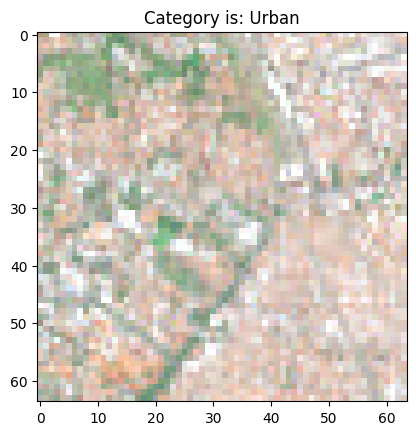

In [19]:
# Visualize Images - note, some categories are not visible due to channels selected
import matplotlib.pyplot as plt

random_index = np.random.choice(subset_labels.shape[0],1)
category_image = subset_images[random_index].reshape(64,64,3)
categories = ["Not Urban", "Urban"] # currently 1 = urban and 0 = not urban
plt.imshow(category_image)
plt.title(f"Category is: {categories[subset_labels[random_index][0]]}")

In [20]:
import sklearn

# split test and train data
from sklearn.model_selection import train_test_split 

# using the train test split function
(X_train, X_test, Y_train, Y_test) = train_test_split(subset_images, subset_labels,
                                                      stratify = subset_labels,
                                                        random_state=104, 
                                                        test_size=0.5, 
                                                        shuffle=True)

In [21]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=180,
    fill_mode='reflect'
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [51]:
train_augmented = train_datagen.flow(
    x = X_train,
    y = Y_train,
    batch_size=100)

In [52]:
test_augmented = test_datagen.flow(
    x = X_test,
    y = Y_test,
    batch_size=100)

In [49]:
train_augmented

In [25]:
# Y_test

# Data Augmentation

In [26]:
# pip install protobuf==3.20.0

In [27]:
# # import libraries
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from matplotlib.pyplot import imread, imshow, subplots, show

In [28]:
# # function to plot augmented images

# def plot(data_generator):
#     """
#     Plots 6 images generated by an object of the ImageDataGenerator class.
#     """
#     data_generator.fit(urban_images_aug)
#     image_iterator = data_generator.flow(urban_images_aug)
    
#     # plot images from iterator
#     fig, rows = subplots(nrows=1, ncols=6, figsize=(18,18))
#     for row in rows:
#         row.imshow(image_iterator.next()[0].astype('int'))
#         row.axis('off')
#     show()
    


In [29]:
# # read in test image
# image_test = imread('./data/cirebon/urban/urban_103.jpg')

# # create dataset with one test image
# images_test = image_test.reshape((1, image_test.shape[0], image_test.shape[1], image_test.shape[2]))

# imshow(images_test[0])
# show()

In [30]:
# apply transformations to test image
# data_generator = ImageDataGenerator(rotation_range=180, fill_mode='reflect')
# # data_generator = ImageDataGenerator(rotation_range=30, fill_mode='reflect')
# plot(data_generator)

In [31]:
# # apply brightness
# data_generator = ImageDataGenerator(brightness_range=(0.7, 1.3))
# plot(data_generator)

# # let's not use this method

In [32]:
# # apply zoom
# data_generator = ImageDataGenerator(zoom_range=[0.2, 2.5])
# plot(data_generator)

# # let's not use this method

In [33]:
# from matplotlib.pyplot import imread, imshow, subplots, show

# # create dataset with all urban images (batch_size, height, width, channels)
# urban_images_aug = urban_images.reshape((urban_images.shape[0], 64, 64, 3))

# imshow(urban_images_aug[33]) # show one image
# show()

In [34]:
# # check dataset shape; should be (114, 64, 64, 3)
# urban_images_aug.shape

In [35]:
# # apply transformations to urban images
# data_generator = ImageDataGenerator(rotation_range=180, fill_mode='reflect')

# plot(data_generator)

In [36]:
# # generate augmented images
# train_generator = data_generator.flow(urban_images_aug, batch_size=32)

In [37]:
# train model on augmented images
# model.fit_generator(train_generator, epochs=10, steps_per_epoch=len(x_train) / 32)

# Model 1 - Self-Made CNN

In [63]:
input_shape = (images.shape[1], images.shape[2], images.shape[3])
num_classes = 2

handmade_cnn = Sequential()
handmade_cnn.add(Conv2D(32, kernel_size=(3, 3), # Conv2D layer - apply 32 convolutions with a 3x3 kernel
                 activation='relu',
                 input_shape=input_shape))
handmade_cnn.add(MaxPooling2D(pool_size=(2, 2))) # Max Pooling 2D layer
handmade_cnn.add(Dropout(0.25)) # drop out
handmade_cnn.add(Flatten()) # flatten before putting into dense network
handmade_cnn.add(Dense(num_classes, activation='softmax')) # dense layer

# comment out summary for space
#handmade_cnn.summary()
#plot_model(handmade_cnn, show_shapes=True, show_layer_names=True)

In [64]:
# compile model
handmade_cnn.compile(
    loss='categorical_crossentropy',
    optimizer = "Adam",
              #optimizer=RMSprop(),
              metrics=['accuracy'])

# convert class vectors to binary class matrices
Y_train_cat = keras.utils.np_utils.to_categorical(Y_train, num_classes)
Y_test_cat = keras.utils.np_utils.to_categorical(Y_test, num_classes)

# train
history_handmade_cnn = handmade_cnn.fit(X_train, Y_train_cat, # training data
                    #batch_size=2000,
                    epochs=100,
                    verbose=1,
                    validation_data= (X_test, Y_test_cat)) # testing data


# history_handmade_cnn = handmade_cnn.fit(train_augmented, Y_train_cat, #X_train, Y_train_cat, # training data
#                     #batch_size=2000,
#                     epochs=100,
#                     verbose=1,
#                     validation_data= (test_augmented, Y_test_cat)) #(X_test, Y_test_cat)) # testing data


Epoch 1/100
4/4 [==============================] - 1s 68ms/step - loss: 593.6644 - accuracy: 0.4474 - val_loss: 33.4821 - val_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 0s 17ms/step - loss: 353.5106 - accuracy: 0.5263 - val_loss: 485.7924 - val_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 280.9931 - accuracy: 0.5000 - val_loss: 103.6594 - val_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 169.6811 - accuracy: 0.5000 - val_loss: 193.1161 - val_accuracy: 0.5000
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 133.0250 - accuracy: 0.5000 - val_loss: 30.0379 - val_accuracy: 0.5000
Epoch 6/100
4/4 [==============================] - 0s 18ms/step - loss: 40.6961 - accuracy: 0.5000 - val_loss: 14.1784 - val_accuracy: 0.5175
Epoch 7/100
4/4 [==============================] - 0s 18ms/step - loss: 5.8210 - accuracy: 0.6754 - val_loss: 5.8078 - val_accuracy: 0.6140


In [65]:
handmade_cnn_score = handmade_cnn.evaluate(X_test, Y_test_cat, verbose=0)
accuracy_handmade_cnn = handmade_cnn_score[1]
print('Handmade Model accuracy:', round(accuracy_handmade_cnn, 3) * 100, "%")

Handmade Model accuracy: 76.3 %


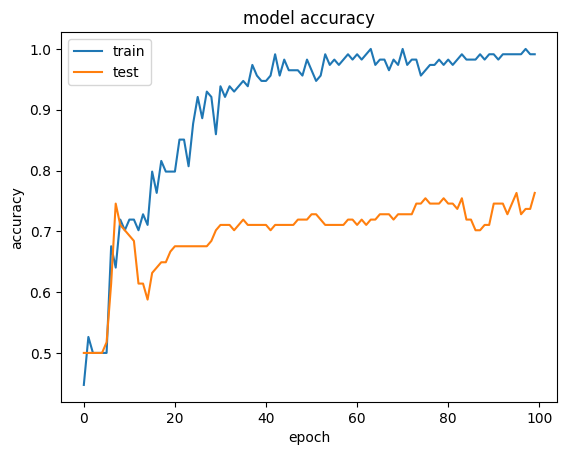

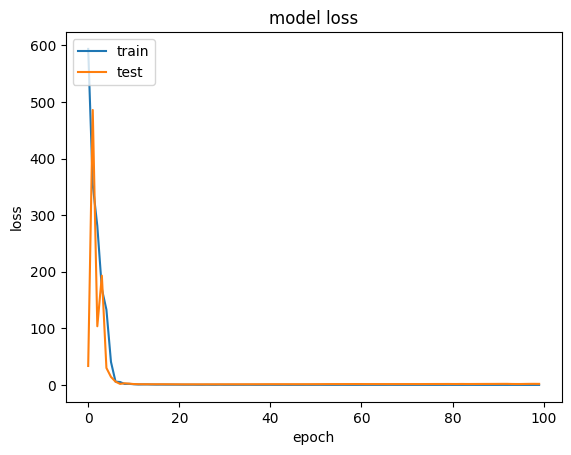

([<matplotlib.lines.Line2D at 0x7f4c76d27be0>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [66]:
plot_accuracy_and_loss(history_handmade_cnn)

## Assess Accuracy

In [67]:
prediction_by_category(handmade_cnn, X_test)

4/4 [==============================] - 0s 5ms/step


<ipython-input-4-77b848b2e311>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,y_true,accurate_preds,label_count,class_acc,overall_acc
0,Not_Urban,38,57,0.666667,0.763158
1,Urban,49,57,0.859649,0.763158


4/4 [==============================] - 0s 3ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f4d1006a8b0>,
 Text(0.5, 1.0, 'Confusion Matrix, Handmade Model'))

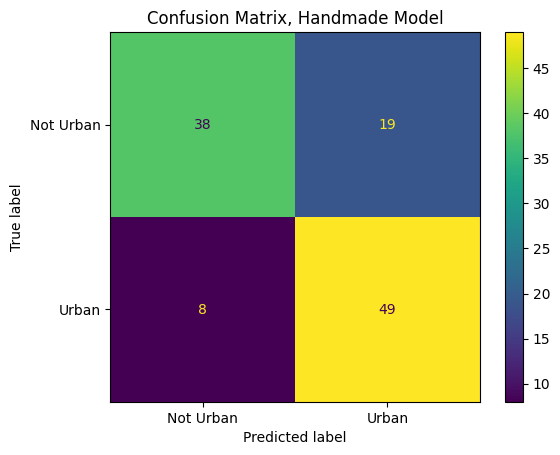

In [68]:
plot_cm(handmade_cnn, X_test, "Confusion Matrix, Handmade Model")

4/4 [==============================] - 0s 3ms/step


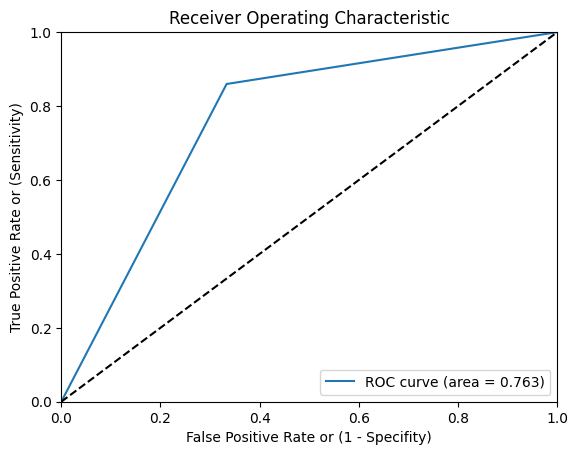

In [69]:
# ROC curve - why so angular?
from sklearn.metrics import roc_curve, auc

predict_x=handmade_cnn.predict(X_test) # predictions with probabilities for each class
classes_x=np.argmax(predict_x,axis=1) # the class with the highest-predicted probabilities, i.e. the best guess
probabilities = handmade_cnn.predict(X_test)
probabilities_2 = np.argmax(probabilities, axis=1)

# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(Y_test, probabilities_2)
#fpr, tpr, thresholds = roc_curve(Y_test, classes_x)
roc_auc = auc(fpr, tpr)

# # Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [ ]:
# probabilities_2

4/4 [==============================] - 0s 4ms/step


([<matplotlib.lines.Line2D at 0x7f4d0f8f3eb0>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f4d0f94bf40>)

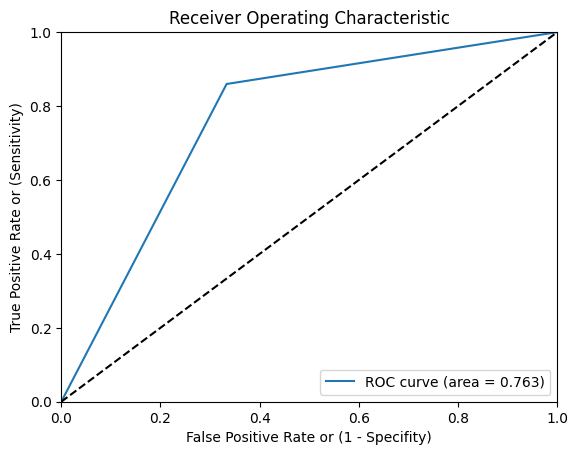

In [70]:
plot_roc_curve(handmade_cnn, X_test)

4/4 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

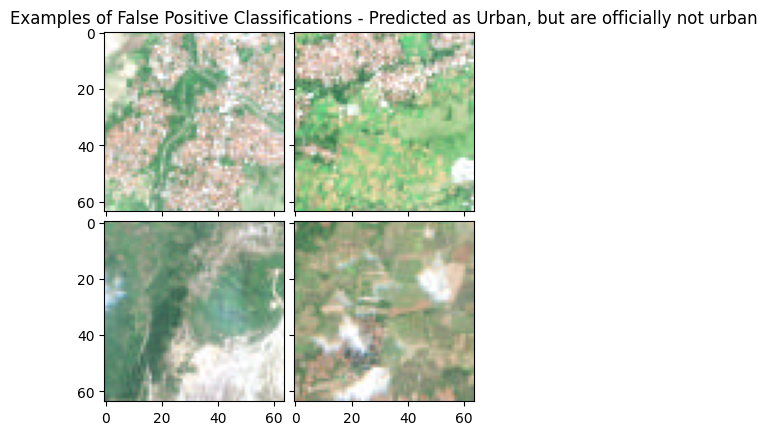

In [72]:
plot_false_positives(handmade_cnn, X_test)

# VGG-16

In [73]:
# load vgg model
from keras.applications.vgg16 import VGG16

# load the model
vgg16 = VGG16(weights='imagenet', include_top = False, input_shape=input_shape) # set VGG to trainable, set VGG to take images shaped as 64*64*3
#vgg16.summary()

# preprocess data for VGG16
from keras.applications.vgg16 import preprocess_input

X_train_vgg = preprocess_input(X_train) # normalize training data
X_test_vgg = preprocess_input(X_test) # normalize test data

58889256/58889256 [==============================] - 0s 0us/step


In [74]:
# Add last layers for our images
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
drop_out_layer = layers.Dropout(0.2)
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

# set model architecture
vgg16_model = models.Sequential([
    vgg16,
    flatten_layer,
    dense_layer_1,
    drop_out_layer,
    dense_layer_2,
    prediction_layer
])

In [82]:
from tensorflow.keras.callbacks import EarlyStopping

vgg16_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# commenting out so it doesn't run accidentally - takes forever to run
history_vgg16 = vgg16_model.fit(X_train_vgg,
            Y_train_cat,
            epochs=50,
            validation_split=0.2,
            batch_size=32,
            callbacks=[es])

Epoch 1/50
3/3 [==============================] - 11s 246ms/step - loss: 1.1222 - accuracy: 0.4945 - val_loss: 0.6812 - val_accuracy: 0.5652
Epoch 2/50
3/3 [==============================] - 0s 79ms/step - loss: 0.6956 - accuracy: 0.4615 - val_loss: 0.7459 - val_accuracy: 0.4348
Epoch 3/50
3/3 [==============================] - 0s 66ms/step - loss: 0.7192 - accuracy: 0.5165 - val_loss: 0.7856 - val_accuracy: 0.4348
Epoch 4/50
3/3 [==============================] - 0s 67ms/step - loss: 0.7160 - accuracy: 0.5495 - val_loss: 0.7471 - val_accuracy: 0.4348
Epoch 5/50
3/3 [==============================] - 0s 84ms/step - loss: 0.6543 - accuracy: 0.5385 - val_loss: 0.6617 - val_accuracy: 0.6522
Epoch 6/50
3/3 [==============================] - 0s 63ms/step - loss: 0.6300 - accuracy: 0.5824 - val_loss: 0.9072 - val_accuracy: 0.5217
Epoch 7/50
3/3 [==============================] - 0s 64ms/step - loss: 0.8135 - accuracy: 0.5385 - val_loss: 1.3004 - val_accuracy: 0.3913
Epoch 8/50
3/3 [=========

In [83]:
vgg16_model_score = vgg16_model.evaluate(X_test_vgg, Y_test_cat, verbose=0)
accuracy_vgg16_model = vgg16_model_score[1]
print('VGG-16 Test accuracy:', round(accuracy_vgg16_model, 3) * 100, "%") 

VGG-16 Test accuracy: 71.1 %


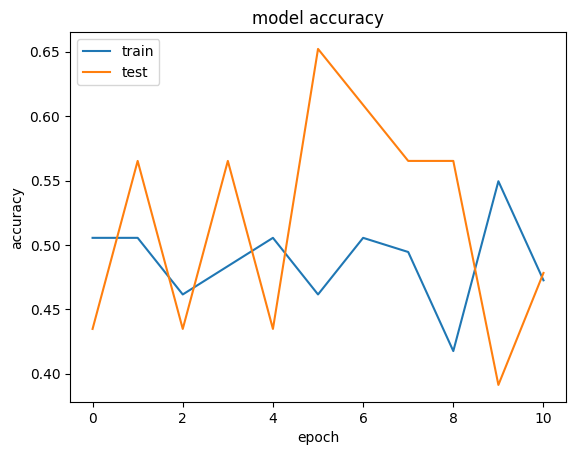

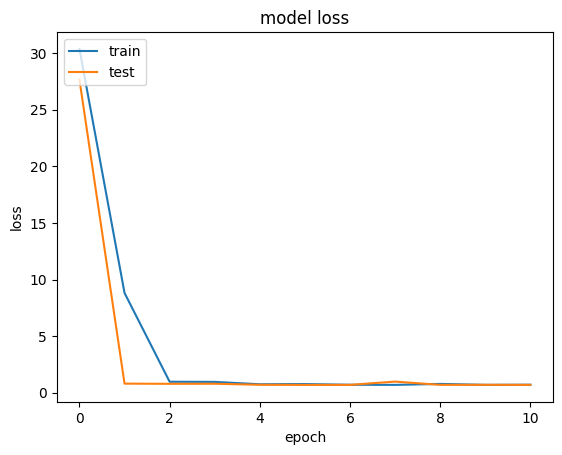

([<matplotlib.lines.Line2D at 0x7f4c74ad1c10>],
 Text(0.5, 1.0, 'model accuracy'),
 Text(24.000000000000007, 0.5, 'accuracy'),
 Text(0.5, 24.0, 'epoch'),
 None,
 Text(0.5, 1.0, 'model loss'),
 Text(24.000000000000007, 0.5, 'loss'),
 Text(0.5, 24.0, 'epoch'),
 None)

In [77]:
plot_accuracy_and_loss(history_vgg16)

In [78]:
prediction_by_category(vgg16_model, X_test_vgg)

4/4 [==============================] - 0s 12ms/step


<ipython-input-4-77b848b2e311>:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()


,y_true,accurate_preds,label_count,class_acc,overall_acc
0,Not_Urban,21,57,0.368421,0.622807
1,Urban,50,57,0.877193,0.622807


4/4 [==============================] - 0s 12ms/step


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f4c703ba730>,
 Text(0.5, 1.0, 'Confusion Matrix: VGG16'))

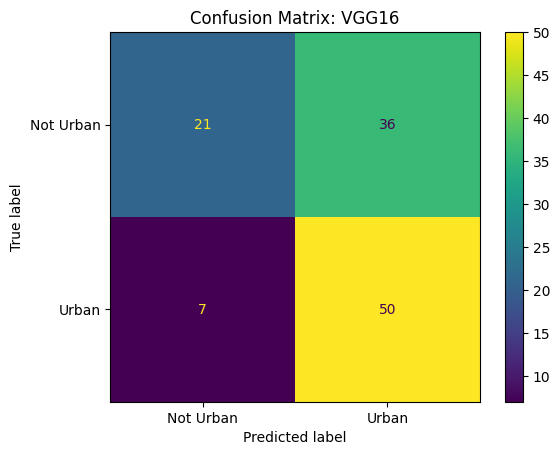

In [79]:
plot_cm(vgg16_model, X_test_vgg, "Confusion Matrix: VGG16")

4/4 [==============================] - 0s 13ms/step


([<matplotlib.lines.Line2D at 0x7f4c7031a2e0>],
 (0.0, 1.0),
 (0.0, 1.0),
 Text(0.5, 0, 'False Positive Rate or (1 - Specifity)'),
 Text(0, 0.5, 'True Positive Rate or (Sensitivity)'),
 Text(0.5, 1.0, 'Receiver Operating Characteristic'),
 <matplotlib.legend.Legend at 0x7f4c7036bee0>)

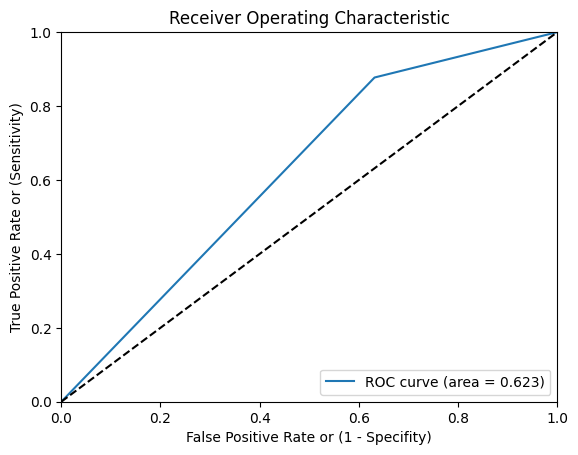

In [80]:
plot_roc_curve(vgg16_model, X_test_vgg)

4/4 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'Examples of False Positive Classifications - Predicted as Urban, but are officially not urban')

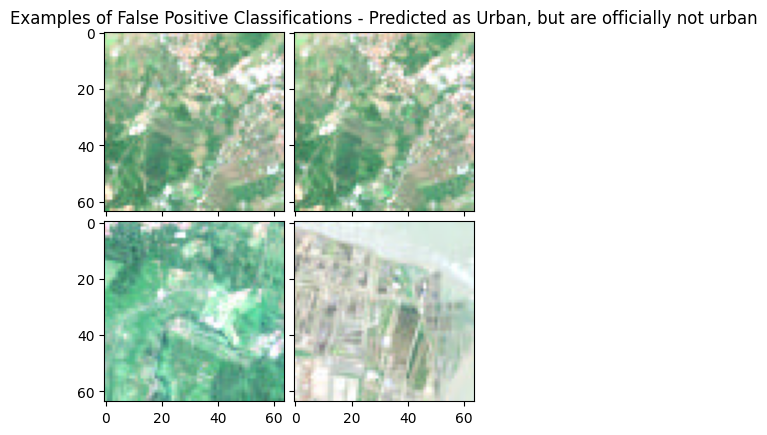

In [81]:
plot_false_positives(vgg16_model, X_test_vgg) # does not work because predicted no positives

# EfficientNet V2
https://arxiv.org/abs/2104.00298

In [ ]:
# # load model
# from keras.applications.efficientnet_v2 import EfficientNetV2S

# # load the model
# eff_net = EfficientNetV2S(weights='imagenet', include_top = False, input_shape=input_shape) # set to trainable, set to take images shaped as 64*64*3
# #eff_net.summary()

# # preprocess data for EfficientNet
# from keras.applications.efficientnet_v2 import preprocess_input

# X_train_EN = preprocess_input(X_train) # normalize training data
# X_test_EN = preprocess_input(X_test) # normalize test data

In [ ]:
# # Add last layers for our images

# flatten_layer = layers.Flatten()
# dense_layer_1 = layers.Dense(50, activation='relu')
# drop_out_layer = layers.Dropout(0.2)
# dense_layer_2 = layers.Dense(20, activation='relu')
# prediction_layer = layers.Dense(num_classes, activation='softmax')

# # set model architecture
# efficient_net_model = models.Sequential([
#     eff_net,
#     flatten_layer,
#     dense_layer_1,
#     drop_out_layer,
#     dense_layer_2,
#     prediction_layer
# ])

In [ ]:
# # Compile
# efficient_net_model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy'],
# )


# es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# # Train
# history_efficient_net = efficient_net_model.fit(X_train_EN,
#             Y_train_cat,
#             epochs=50,
#             validation_split=0.2,
#             batch_size=32,
#             callbacks=[es])

In [ ]:
# efficient_net_model_score = efficient_net_model.evaluate(X_test_EN, Y_test_cat, verbose=0)
# accuracy_eff_net = efficient_net_model_score[1]
# print('EfficientNetV2 Test accuracy:', round(accuracy_eff_net, 3) * 100, "%") 

In [ ]:
# plot_accuracy_and_loss(history_efficient_net)

In [ ]:
# prediction_by_category(efficient_net_model, X_test_EN)

In [ ]:
# plot_cm(efficient_net_model, X_test_EN, "Confusion Matrix, EfficicentNetV2")

In [ ]:
# plot_roc_curve(efficient_net_model, X_test_EN)

In [ ]:
# plot_false_positives(efficient_net_model, X_test_EN)